In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Sample problem, Symmetric Positive Definite Matrix
A = np.array([[3,2],[2,6]])
b = np.array([2,-8])
c = 0

### Quadratic Form
I'm trying to plot the Quadratic Form of $\mathbf{A},\vec{b},\vec{c}$
$$ f(x) = \frac{1}{2} \vec{x}^T\mathbf{A}\vec{x} - \vec{b}^T\vec{x} + c$$

### Gradients, Directions, 
$$ f'(x) = \frac{1}{2} A^Tx + \frac{1}{2} A x - b$$
If A is symmetric, then
$$f'(x) = Ax - b \quad \quad f(p) = f(x) + \frac{1}{2}(p-x)^T.A.(p-x)$$

In [3]:
def quadratic_form(x, y, A,b,c):
    # Create the vector [x, y] and calculate the quadratic form
    vec = np.array([x, y])
    return 0.5*vec.T @ A @ vec + b.T @ vec + c

def gradient_quadratic_form(x,y,A):
    vec = np.array([x,y])
    return A @ vec


In [4]:
# generate a grid of points like [[x1,y1],[x2,y2],[x3,y3]] and evalue f at each point
ext,divs = 5,27
x = np.linspace(-ext,ext,divs)
y = np.linspace(-ext,ext,divs)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = quadratic_form(X[i, j], Y[i, j], A,b,c)

# Gradients
dZdx,dZdy = np.gradient(Z,x,y)

print(X.shape,Y.shape,Z.shape,dZdx.shape,dZdy.shape)

(27, 27) (27, 27) (27, 27) (27, 27) (27, 27)


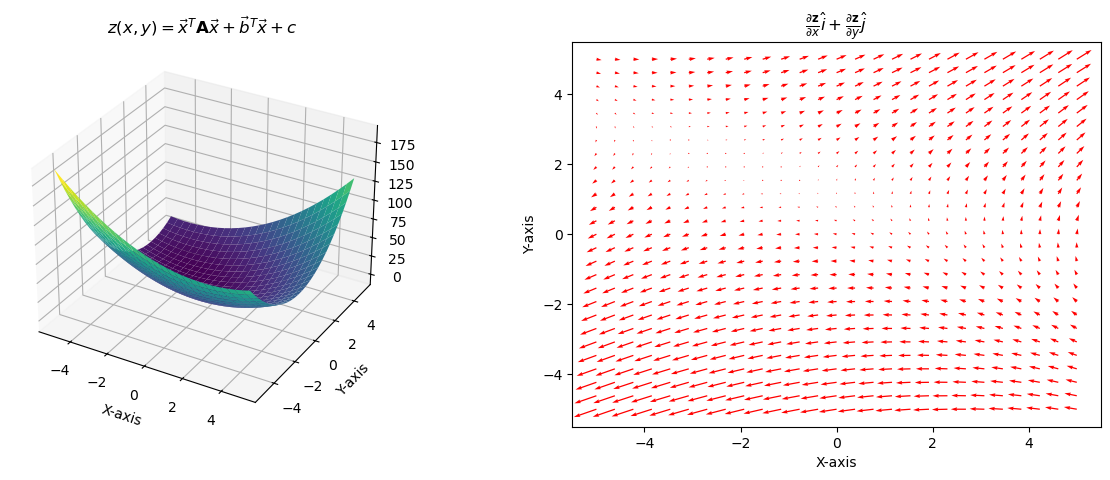

In [5]:
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')
ax1.set_title('$z(x,y) = \\vec{x}^T \\mathbf{A} \\vec{x} + \\vec{b}^T \\vec{x} + c$')

ax2 = fig.add_subplot(122)
ax2.quiver(X, Y, dZdx, dZdy, angles='xy', scale_units='xy', scale=100, color='r')
ax2.set_xlabel('X-axis')
ax2.set_ylabel('Y-axis')
ax2.set_title("$\\frac{\\partial \\mathbf{z}}{\\partial x}\\hat{i} + \\frac{\\partial \\mathbf{z}}{\\partial y}\\hat{j}$")

plt.show()

I'm trying to plot the normal-plane slicing this surface at a specific point $\vec{x}_p$ \
The normal-plane must lie along the gradient vector $\vec{g}_p = \mathbf{A}\vec{x}_p + \vec{b} = \frac{\partial z(x,y)}{\partial x} \hat{i} + \frac{\partial z(x,y)}{\partial y} \hat{j} $ \
Once you know the gradient $\vec{g}_p$ at point $\vec{x}_p$, you can evaluate the normal-vector $\vec{n}_p = \frac{\partial z(x,y)}{\partial x} \vert_{x_p} \hat{i} + \frac{\partial z(x,y)}{\partial y} \vert_{y_p} \hat{j} -\hat{k}$ because the gradient is normal to the surface. \
Now that we know the normal at the point, we need to find another vector that also lies on the normal-plane so that we have the complete span for the normal-plane and we can construct the normal-plane.
The tangent plane is given by $z = z_p + \frac{\partial z}{\partial x}\vert_{x_p} (x-x_p) + \frac{\partial z}{\partial y} \vert_{y_p}(y-y_p)$

the gradient vector is tangent to the surface 
the normal vector is perpendicular to this gradient vector

given the surface f(x,y) = z 
now consider another surface F(x,y) = f(x,y) - z = 0
The gradient of the F surface is normal to the f surface



In [25]:
xp, yp = 1, 2
zp = quadratic_form(xp, yp, A,b,c)
gp = gradient_quadratic_form(xp, yp, A)
dfdx, dfdy = gp

# plotting the tangent plane to the surface at (x,y) = (1,2)
# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the normal. Thus, we have to calculate d and we're set
point = np.array([xp,yp,zp])
normal = np.array([dfdx,dfdy,-1])
d = -point.dot(normal)
# c = -1, so a*x + b*y -z + d = 0 or z = a*x + b*y + d
z_tangent = -(normal[0] * X + normal[1] * Y + d)

# normal surface
xx = np.linspace(xp - 0.5*dfdx, xp + 0.5*dfdx,10)
yy = np.linspace(yp - 0.5*dfdx, yp + 0.5*dfdy,10)
XX, YY = np.meshgrid(xx,yy)
z_normal = (dfdx * XX + dfdy * YY) + d

Text(0.5, 0.92, '$z(x,y) = \\vec{x}^T \\mathbf{A} \\vec{x} + \\vec{b}^T \\vec{x} + c$')

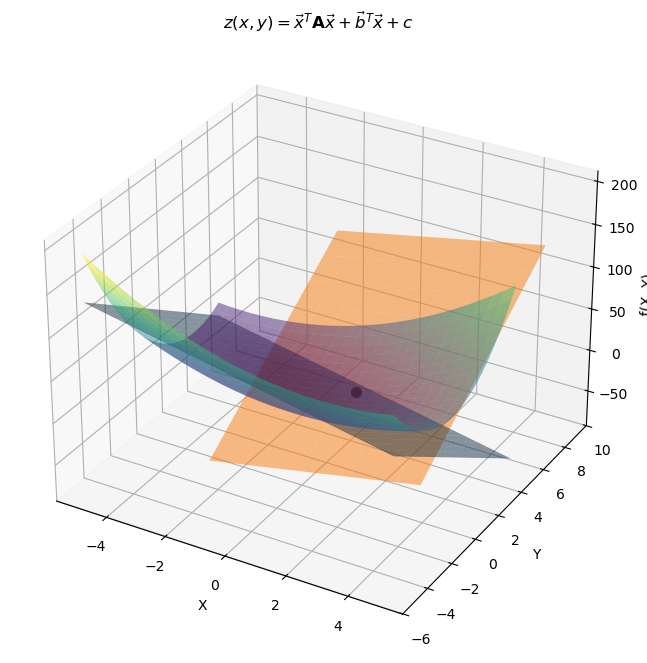

In [26]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, Z, cmap='viridis',alpha=0.5)
ax.plot_surface(X,Y, z_tangent,alpha=0.5)
ax.plot_surface(XX,YY, z_normal,alpha=0.5)
# ax.plot_surface(X_plane, Y_plane, Z_plane, alpha=0.3, color='red', edgecolor='k')

# Plot the point (1, 2, f(1,2))
ax.scatter(xp, yp, zp, color='black', s=50, label='Point (1,2) on surface')


# Add labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(X, Y)')

ax.set_title('$z(x,y) = \\vec{x}^T \\mathbf{A} \\vec{x} + \\vec{b}^T \\vec{x} + c$')


The goal is to find a sequence of steps $x^{(1)},x^{(2)},...x^{(n)}$ that converge to the minima of the bowl \
\begin{equation}
\begin{split}
-\vec{f'}(\vec{x}^{(i)}) &= \vec{b} - \mathbf{A} \vec{x}^{(i)} \quad \quad \text{Direction of each step, negative of the gradient} \\
\vec{e}^{(i)} &= \vec{x}^{(i)} - \vec{x} \quad \quad \text{Error at each step, difference between "true" x and computed} \\
\vec{r}^{(i)} &= \vec{b} - \mathbf{A}\vec{x}^{(i)} \quad \quad \text{Residual at each step, difference between "true" b and computed } \\
\vec{r^{(i)}} &= \mathbf{A}\vec{e^{(i)}} = \vec{f'}(\vec{x}^{(i)})
\end{split}
\end{equation}
You could think of the Residual as a tranformation of $\vec{e}$ into $\vec{b}$ and it's equal to the "direction of steepest descent" 
$$ \therefore \vec{x}^{(i+1)} = \vec{x}^{(i)} + \alpha \vec{r}^{(i)}$$
$\alpha$ is the "learning rate". How do you set $\alpha$? 
For a given iteration, $\vec{x}^{(i+1)}$, the step-direction is $\vec{r}^{(i)}$ and $\alpha$s is the "multiplier". The plot of $f(p + \alpha r) vs \alpha $ is obtained by taking a slice on the bowl. A plane cuts across the bowl. The plane passes through the point $p$ and is parallel to $r$. This gives a parabola. \
$\alpha$ minimizes $\vec{f}$ when the derivative $\partial f/\partial \alpha = 0$ \
By taking the chain rule we get 
$$ \frac{\partial \vec{f}(\vec{x^{(i+1)}})}{\partial \alpha} = \frac{\partial \vec{f}(\vec{x}^{(i+1)})}{\partial \vec{x}^{(i+1)}} \frac{\partial \vec{x}^{(i+1)}}{\partial \alpha} = \frac{\partial \vec{f}(\vec{x}^{(i+1)})}{\partial \vec{x}^{(i+1)}} \vec{r}^{(i)}$$

Therefore to minimize $\vec{f}(\vec{x}^{(i+1)})$ we need to choose $\alpha$ such that $\vec{r}^{(i)}$ and the gradient $\vec{f}'(\vec{x}^{(i+1)})$ are orthogonal